In [2]:
import sys
sys.version

'2.7.12 (default, Nov 12 2018, 14:36:49) \n[GCC 5.4.0 20160609]'

# Data Process

In [3]:
#import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import joblib
#import scipy.misc
import tensorflow as tf
#from skimage.restoration import denoise_tv_chambolle
from tensorboardX import SummaryWriter
import copy

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [5]:
pp_path = '/home/obin/t2b_dataset/rgbd/image'
data_list = np.sort([pp_path+'/'+x for x in os.listdir(os.path.join(pp_path,''))])
# pp_path = '/home/obin/t2b_dataset/pickandplace/temp/0202'
# data_list2 = np.sort([pp_path+'/'+x for x in os.listdir(os.path.join(pp_path,''))])
# data_list = np.hstack((data_list[0:-1],data_list2))
num_data = len(data_list)
print('num of data : ', num_data)

('num of data : ', 1000)


In [6]:
def pretty_print_input(arr, ori = False):
    arr = np.squeeze(arr)
    if ori == True : 
        s_x, s_y, s_d, s_ori = arr[0:4]
        g_x, g_y, g_d, g_ori = arr[4:8]
        
        print('start pixel        goal pixek')
        print('x : %04f    x : %04f'%(s_x,g_x))
        print('y : %04f    y : %04f'%(s_y,g_y))
        print('z : %04f    z : %04f'%(s_d,g_d))
        print('o : %04f    o : %04f'%(s_ori,g_ori))
        print('\n')
    else : 
        s_x, s_y, s_d = arr[0:3]
        g_x, g_y, g_d = arr[3:6]
        
        print('start pixel        goal pixek')
        print('x : %04f    x : %04f'%(s_x,g_x))
        print('y : %04f    y : %04f'%(s_y,g_y))
        print('z : %04f    z : %04f'%(s_d,g_d))
        print('\n')
    
    
def pretty_print_out(arr):
    arr = np.squeeze(arr)
    s_px, s_py, s_pz, s_ox, s_oy, s_oz, s_ow = arr[0:7]
    g_px, g_py, g_pz, g_ox, g_oy, g_oz, g_ow = arr[7:14]
    
    print('start pose        goal pose')
    print('x : %04f    x : %04f'%(s_px,g_px))
    print('y : %04f    y : %04f'%(s_py,g_py))
    print('z : %04f    z : %04f'%(s_pz,g_pz))
    print('x : %04f    x : %04f'%(s_ox,g_ox))
    print('y : %04f    y : %04f'%(s_oy,g_oy))
    print('z : %04f    z : %04f'%(s_oz,g_oz))
    print('w : %04f    w : %04f'%(s_ow,g_ow))
    print('\n')
    


## depth image preprocess

In [7]:
#np.random.shuffle(data_list)
data_list

array(['/home/obin/t2b_dataset/rgbd/image/0000.png',
       '/home/obin/t2b_dataset/rgbd/image/0001.png',
       '/home/obin/t2b_dataset/rgbd/image/0002.png',
       '/home/obin/t2b_dataset/rgbd/image/0003.png',
       '/home/obin/t2b_dataset/rgbd/image/0004.png',
       '/home/obin/t2b_dataset/rgbd/image/0005.png',
       '/home/obin/t2b_dataset/rgbd/image/0006.png',
       '/home/obin/t2b_dataset/rgbd/image/0007.png',
       '/home/obin/t2b_dataset/rgbd/image/0008.png',
       '/home/obin/t2b_dataset/rgbd/image/0009.png',
       '/home/obin/t2b_dataset/rgbd/image/0010.png',
       '/home/obin/t2b_dataset/rgbd/image/0011.png',
       '/home/obin/t2b_dataset/rgbd/image/0012.png',
       '/home/obin/t2b_dataset/rgbd/image/0013.png',
       '/home/obin/t2b_dataset/rgbd/image/0014.png',
       '/home/obin/t2b_dataset/rgbd/image/0015.png',
       '/home/obin/t2b_dataset/rgbd/image/0016.png',
       '/home/obin/t2b_dataset/rgbd/image/0017.png',
       '/home/obin/t2b_dataset/rgbd/image/0018

In [8]:
def overlap(r1,r2):
    hoverlaps = not((r1[0] > r2[1]) or (r1[1] < r2[0]))
    voverlaps = not((r1[3] < r2[2]) or (r1[2] > r2[3]))
    return hoverlaps and voverlaps  

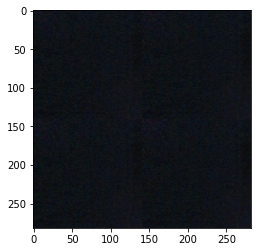

In [22]:
img = cv2.imread('/home/obin/t2b_dataset/rgbd/image/0012.png')
black_patch = img[10:151,10:151,:]
black_patch = cv2.cvtColor(black_patch,cv2.COLOR_BGR2RGB)
black_patch = np.hstack([black_patch,black_patch])
black_patch = np.vstack([black_patch,black_patch])
plt.imshow(black_patch)

In [10]:
safe_distance = 5
max_move1 = 30
max_move2 = 20

In [11]:
def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        #cv2.circle(i,(x,y),10000,(255,0,0),-1)
        mouseX,mouseY = x,y
        #print('point x:{0}, y:{1}'.format(mouseX,mouseY))

In [12]:
def extract_hulls(img):
    kernel = np.ones((3,3),np.float32)/(3*2)
    img = cv2.filter2D(img,-1,kernel)
    for tx in range(256):
        for ty in range(256):
            color = np.array(img[tx,ty,:],dtype=np.int64)
            if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
                img[tx,ty,:] = [30,30,30]

    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray,50,255,0)
    image, contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    hulls = []
    for c in contours :
        if np.array(c).shape[0] <= 1 : continue
        hulls.append(cv2.convexHull(c))
        
    return hulls
    

In [13]:
def extract_objects(img,hulls,safe_distance=5):
    object_list = []
    for h in hulls :
        x = np.array(h).squeeze()[:,0]
        y = np.array(h).squeeze()[:,1]
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        #out = np.zeros_like(img)
        dx = bottomx - topx
        dy = bottomy - topy


        out = img[topy:bottomy+1,topx:bottomx+1:]
        mean = np.mean(out, axis=(0,1))

        if dx*dy <= 800 : continue
        if (abs(mean[0] - mean[1]) < 20)and(abs(mean[1] - mean[2]) < 20) : continue
            
        obj = [topx-safe_distance,bottomx+safe_distance,
               topy-safe_distance,bottomy+safe_distance]
    
        object_list.append(np.clip(obj,0,255))
    return object_list

In [14]:
def where_is(pose,objs):
    for idx, obj in enumerate(objs):
        x_ok = obj[0] < pose[0] and obj[1] > pose[0] 
        y_ok = obj[2] < pose[1] and obj[3] > pose[1]
        
        if x_ok and y_ok : return idx
    return -1
            

In [15]:
def move_object(ids,move,object_list,img,black_patch):
    #print('move ', move)
    ob = object_list[ids]
    
    moved_ob = np.array(ob-move,dtype=np.int64)
    if not(all(moved_ob<255) and all(moved_ob>0)) : 
        return False, None, None
    #   print('moved', moved_ob)
    safe_flag = False
    for other_ob in object_list :
        if overlap(moved_ob,other_ob) and any(other_ob != ob) :
            safe_flag=False
            return False, None, None
        safe_flag = True
    object_img = copy.deepcopy(img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:])

    if safe_flag : 
        dy = ob[3] - ob[2] + 1
        dx = ob[1] - ob[0] + 1
        img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:] = black_patch[0:dy,0:dx,:]
        img[moved_ob[2]:moved_ob[3]+1, moved_ob[0]:moved_ob[1]+1, :] = object_img
        object_list[ids] = moved_ob
        return True, img, object_list

    return False, None, None

In [14]:
orig_imgs = []
end_scenario = []
resume = 0
white_image = np.zeros((30,300))
message = ''
for i in range(resume, num_data-1):
    s_img = cv2.imread(data_list[i])
    e_img = cv2.imread(data_list[i+1])

    s_hulls = extract_hulls(s_img)
    e_hulls = extract_hulls(e_img)

    s_objs = extract_objects(s_img,s_hulls,safe_distance=safe_distance)
    e_objs = extract_objects(e_img,e_hulls,safe_distance=safe_distance)

    images = np.hstack([s_img,e_img])
    data_dict = dict()
    pair_idx = []
    no_care_idx = []
    while True : 
        winname = '%04d'%i
        cv2.namedWindow(winname)
        cv2.moveWindow(winname,350,500)
        cv2.imshow(winname,images)
        cv2.setMouseCallback(winname,draw_circle)           
        key = cv2.waitKey(1)
        
        try :
            pose = np.array([mouseX,mouseY],dtype=np.int64)
            if pose[0] < 255: 
                s_idx = where_is(pose,s_objs)
                curr_s_obj = s_objs[s_idx] if s_idx != -1 else None
                if curr_s_obj is not None :
                    images = cv2.rectangle(images,(curr_s_obj[0],curr_s_obj[2]),
                                           (curr_s_obj[1],curr_s_obj[3]),(0,255,0),-1)
                
                e_idx = where_is(pose,e_objs)
                curr_e_obj = e_objs[e_idx] if e_idx != -1 else None
                if curr_e_obj is not None :
                    images = cv2.rectangle(images,(curr_e_obj[0]+255,curr_e_obj[2]),
                                           (curr_e_obj[1]+255,curr_e_obj[3]),(0,255,0),-1)
                    # find object in start image
            elif pose[0] > 255: 
                e_idx = where_is(pose-[255,0],e_objs)
                curr_e_obj = e_objs[e_idx] if e_idx != -1 else None
                if curr_e_obj is not None :
                    images = cv2.rectangle(images,(curr_e_obj[0]+255,curr_e_obj[2]),
                                           (curr_e_obj[1]+255,curr_e_obj[3]),(0,255,0),-1)

        except :
            pass

        
        #if message is not '' : print(message)
        cv2.namedWindow('white')
        cv2.moveWindow('white',350,350)
        cv2.putText(white_image,message, (5,25), cv2.FONT_HERSHEY_DUPLEX , 0.8, (255,255,255))
        cv2.imshow('white',white_image)
        
        if key & 0xFF == ord('d'):
            cv2.destroyAllWindows()
            mouseX = -1
            mouseY = -1
            
            data_dict['start_image'] = cv2.cvtColor(s_img,cv2.COLOR_BGR2RGB)
            data_dict['end_image'] = cv2.cvtColor(e_img,cv2.COLOR_BGR2RGB)
            data_dict['pair_idx'] = pair_idx
            data_dict['no_care_idx'] = no_care_idx
            data_dict['start_objects'] = s_objs
            data_dict['end_objects'] = e_objs
            data_dict['start_hulls'] = s_hulls
            data_dict['end_hulls'] = e_hulls

            data_name = os.path.join('/home/obin/t2b_dataset/rgbd/sampled', '%04d.dat.gz'%i)
            joblib.dump(data_dict,data_name)
            print(data_name)
            white_image = np.zeros((30,300))
            message = 'saved %04d data'%i
            break
        
        elif key & 0xFF == ord('s') :
            # same object
            try :
                pair_idx.append([s_idx,e_idx])
                print('same object s-{0}, e-{1}'.format(s_idx,e_idx))
                randcolor = np.random.randint(0,200,size=3)+ np.array([0,55,55])
                images = cv2.rectangle(images,(curr_s_obj[0],curr_s_obj[2]),
                                               (curr_s_obj[1],curr_s_obj[3]),randcolor,-1)
                images = cv2.rectangle(images,(curr_e_obj[0]+255,curr_e_obj[2]),
                                               (curr_e_obj[1]+255,curr_e_obj[3]),randcolor,-1)

                mouseX = -1
                mouseY = -1
                white_image = np.zeros((30,300))
                message = 'saved same pair'
            except:
                white_image = np.zeros((30,300))
                message = 'error!, try again'
                mouseX = -1
                mouseY = -1
        elif key & 0xFF == ord('a'):
            try:
                if pose[0] < 255 : 
                    print('no care - s-{0}'.format(s_idx))
                    no_care_idx.append([0,s_idx])
                    randcolor = np.random.randint(10,200,size=3) + np.array([55,0,0]) 
                    images = cv2.rectangle(images,(curr_s_obj[0],curr_s_obj[2]),
                                               (curr_s_obj[1],curr_s_obj[3]),randcolor,-1)
                elif pose[0] > 255 :
                    print('no care - e-{0}'.format(e_idx))
                    no_care_idx.append([1,e_idx])
                    randcolor = np.random.randint(10,200,size=3) + np.array([55,0,0])
                    images = cv2.rectangle(images,(curr_e_obj[0]+255,curr_e_obj[2]),
                                               (curr_e_obj[1]+255,curr_e_obj[3]),randcolor,-1)
                mouseX = -1
                mouseY = -1
                white_image = np.zeros((30,300))
                message = 'saved no-care-object'
            except:
                white_image = np.zeros((30,300))
                message = 'error!, try again'
                mouseX = -1
                mouseY = -1
            
        elif key & 0xFF == ord('q') : 
            cv2.destroyAllWindows()
            break
        elif key & 0xFF == ord('w') :
            print('not related')
            end_scenario.append(i)
            cv2.destroyAllWindows()
            mouseX = -1
            mouseY = -1
            white_image = np.zeros((30,300))
            message = 'next image set'
            break
        elif key & 0xFF == ord('r') : 
            print('reset')
            cv2.destroyAllWindows()
            images = np.hstack([s_img,e_img])
            pair_idx = []
            no_care_idx = []
            mouseX = -1
            mouseY = -1
            white_image = np.zeros((30,300))
            message = 'reset'
            

            
    
    
    if key & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

    

same object s-2, e-1
same object s-0, e-0
no care - s-1
/home/obin/t2b_dataset/rgbd/sampled/0000.dat.gz
no care - s-1
same object s-0, e-0
/home/obin/t2b_dataset/rgbd/sampled/0001.dat.gz
not related
no care - s-1
same object s--1, e--1
same object s-0, e-0
same object s-2, e-1
/home/obin/t2b_dataset/rgbd/sampled/0003.dat.gz
no care - s-1
same object s-0, e-0
/home/obin/t2b_dataset/rgbd/sampled/0004.dat.gz
not related
same object s-2, e-1
same object s-1, e-0
no care - s-0
/home/obin/t2b_dataset/rgbd/sampled/0006.dat.gz
no care - s-1
same object s-0, e-0
/home/obin/t2b_dataset/rgbd/sampled/0007.dat.gz
not related
same object s-2, e-1
no care - s-1
same object s-0, e-0
no care - e-2
/home/obin/t2b_dataset/rgbd/sampled/0009.dat.gz
same object s-1, e-0
same object s-2, e-1
no care - s-0
/home/obin/t2b_dataset/rgbd/sampled/0010.dat.gz
no care - s-0
same object s-1, e-0
/home/obin/t2b_dataset/rgbd/sampled/0011.dat.gz
not related
same object s-2, e-1
no care - s-1
same object s-0, e-0
no care

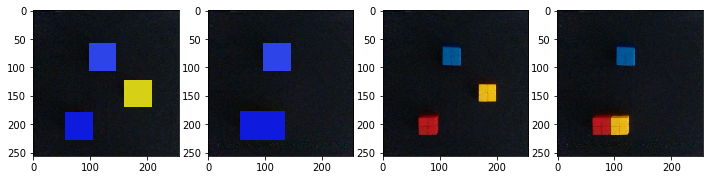

/home/obin/t2b_dataset/rgbd/sampled/0000.dat.gz


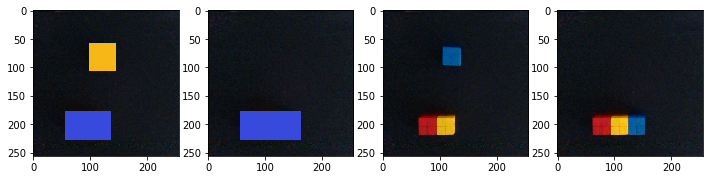

/home/obin/t2b_dataset/rgbd/sampled/0001.dat.gz


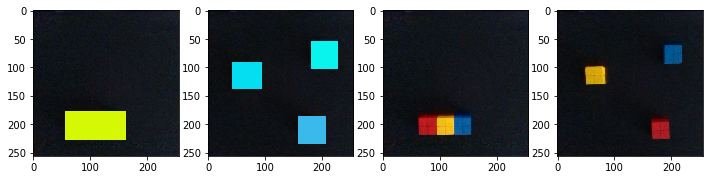

--------------------------------------------------
end





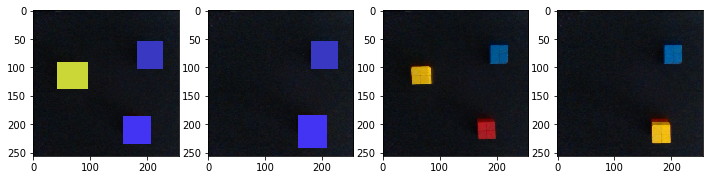

/home/obin/t2b_dataset/rgbd/sampled/0003.dat.gz


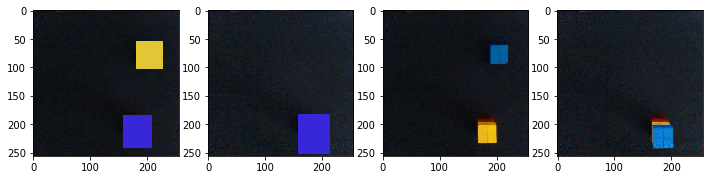

/home/obin/t2b_dataset/rgbd/sampled/0004.dat.gz


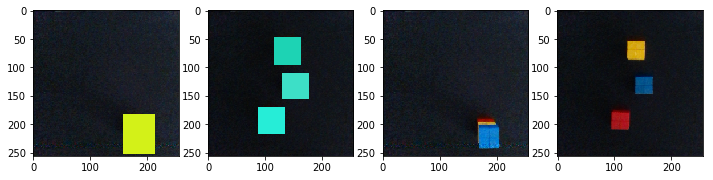

--------------------------------------------------
end





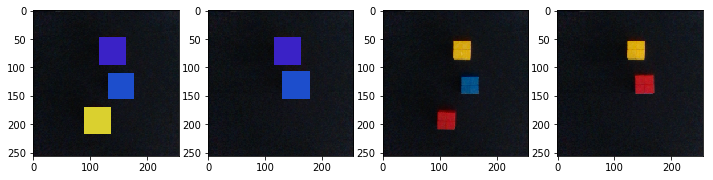

/home/obin/t2b_dataset/rgbd/sampled/0006.dat.gz


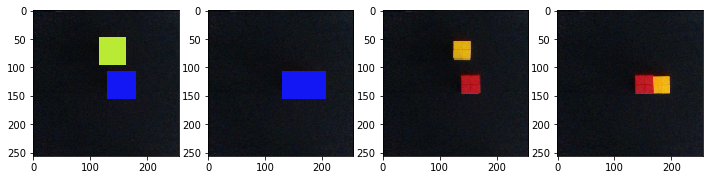

/home/obin/t2b_dataset/rgbd/sampled/0007.dat.gz


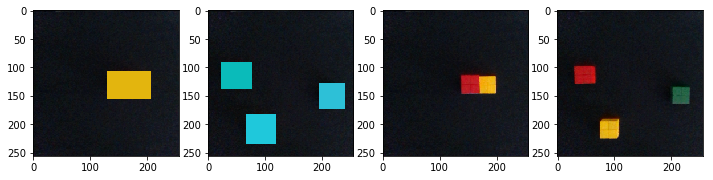

--------------------------------------------------
end





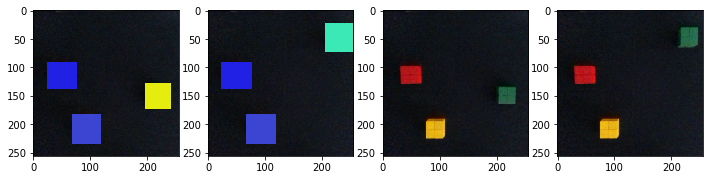

/home/obin/t2b_dataset/rgbd/sampled/0009.dat.gz


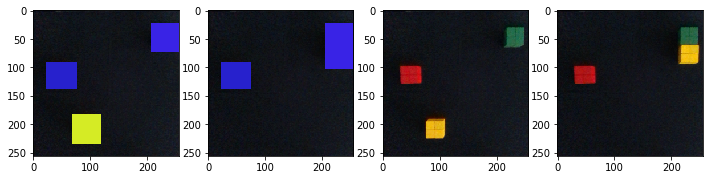

/home/obin/t2b_dataset/rgbd/sampled/0010.dat.gz


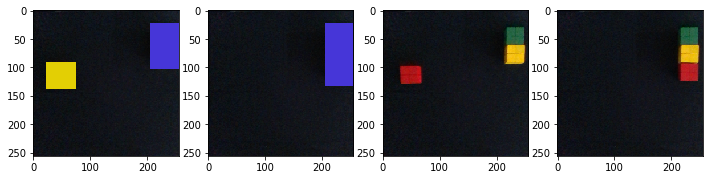

/home/obin/t2b_dataset/rgbd/sampled/0011.dat.gz


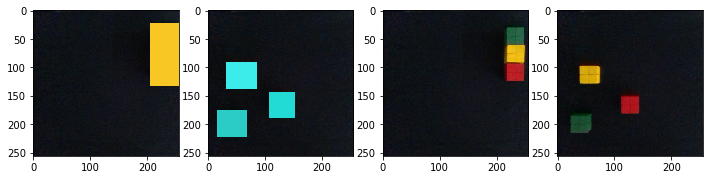

--------------------------------------------------
end





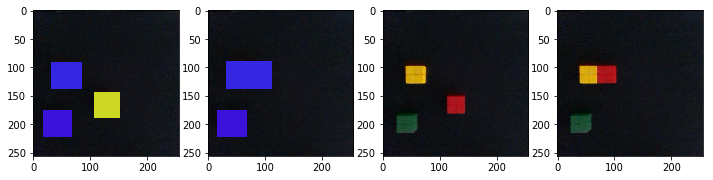

/home/obin/t2b_dataset/rgbd/sampled/0013.dat.gz


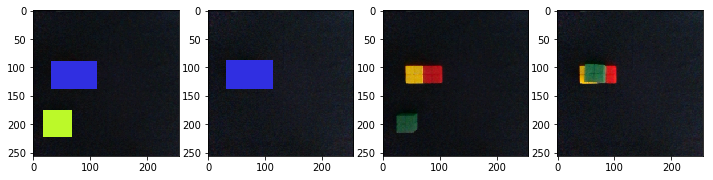

/home/obin/t2b_dataset/rgbd/sampled/0014.dat.gz


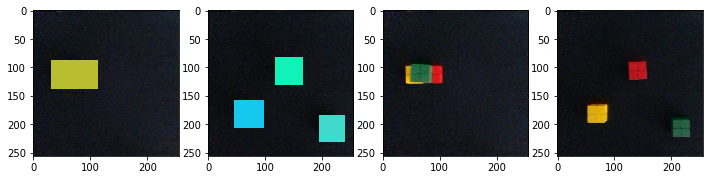

--------------------------------------------------
end





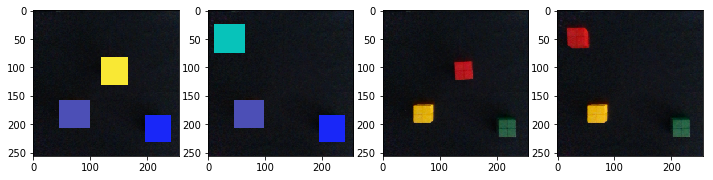

/home/obin/t2b_dataset/rgbd/sampled/0016.dat.gz


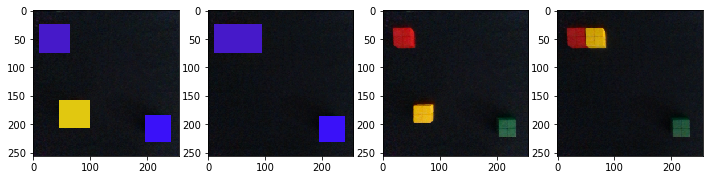

/home/obin/t2b_dataset/rgbd/sampled/0017.dat.gz


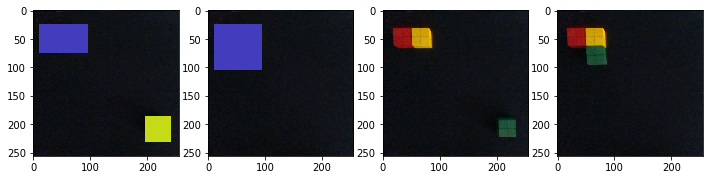

/home/obin/t2b_dataset/rgbd/sampled/0018.dat.gz


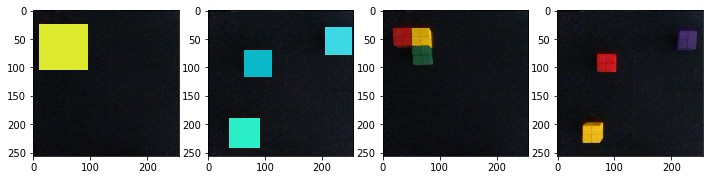

--------------------------------------------------
end





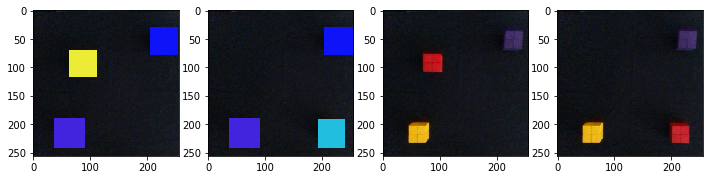

/home/obin/t2b_dataset/rgbd/sampled/0020.dat.gz


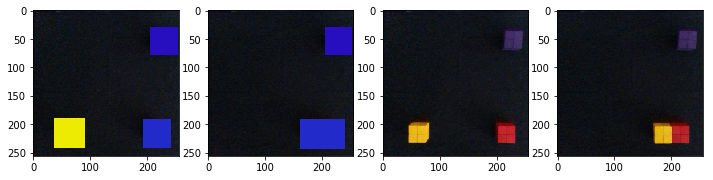

/home/obin/t2b_dataset/rgbd/sampled/0021.dat.gz


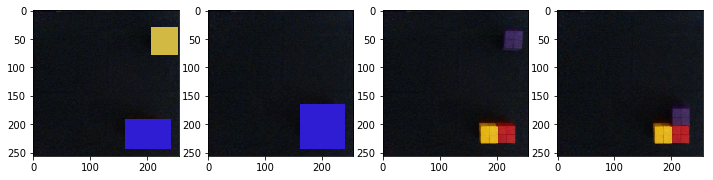

/home/obin/t2b_dataset/rgbd/sampled/0022.dat.gz


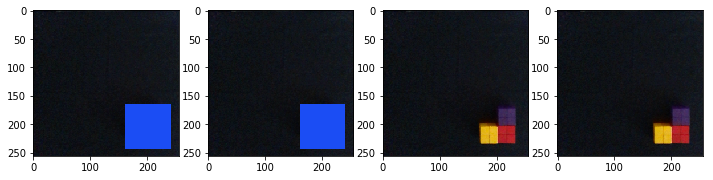

/home/obin/t2b_dataset/rgbd/sampled/0023.dat.gz


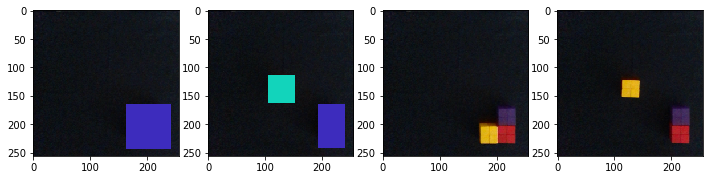

/home/obin/t2b_dataset/rgbd/sampled/0024.dat.gz


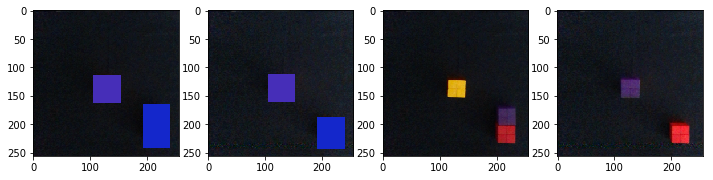

/home/obin/t2b_dataset/rgbd/sampled/0025.dat.gz


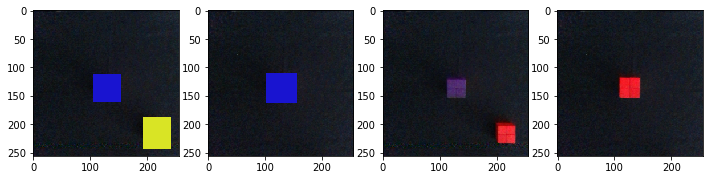

/home/obin/t2b_dataset/rgbd/sampled/0026.dat.gz


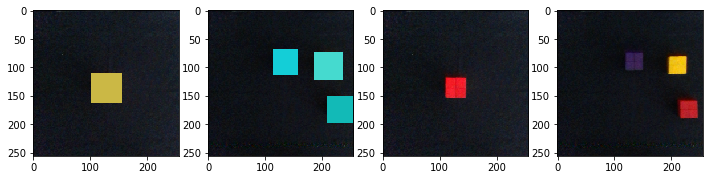

--------------------------------------------------
end





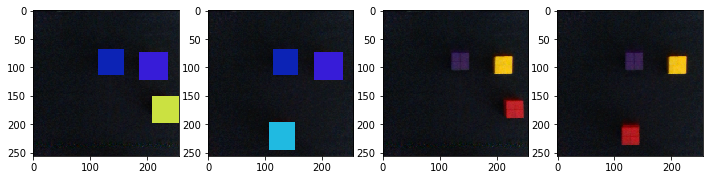

/home/obin/t2b_dataset/rgbd/sampled/0028.dat.gz


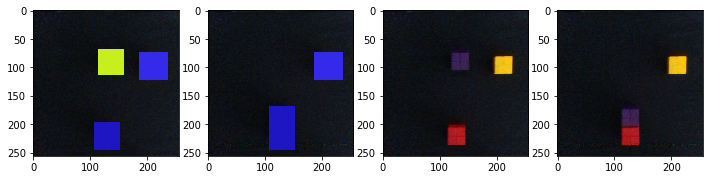

/home/obin/t2b_dataset/rgbd/sampled/0029.dat.gz


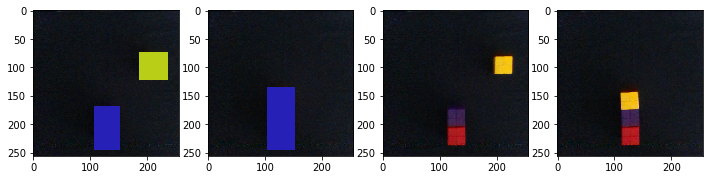

/home/obin/t2b_dataset/rgbd/sampled/0030.dat.gz


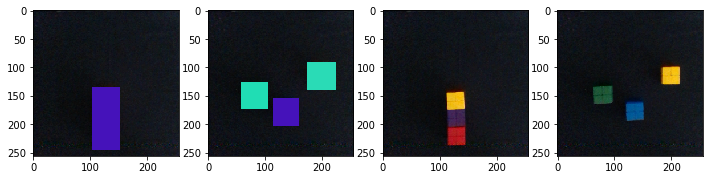

/home/obin/t2b_dataset/rgbd/sampled/0031.dat.gz


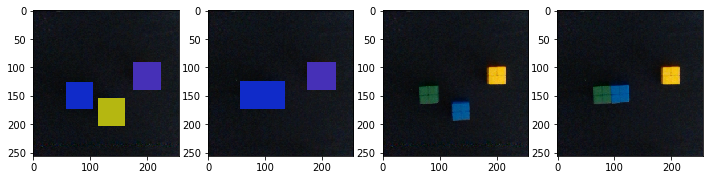

/home/obin/t2b_dataset/rgbd/sampled/0032.dat.gz


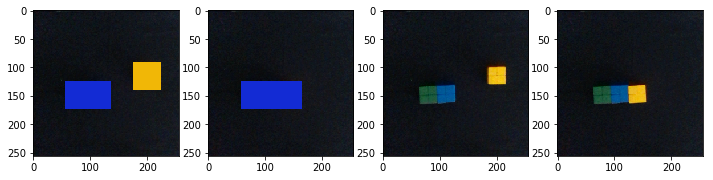

/home/obin/t2b_dataset/rgbd/sampled/0033.dat.gz


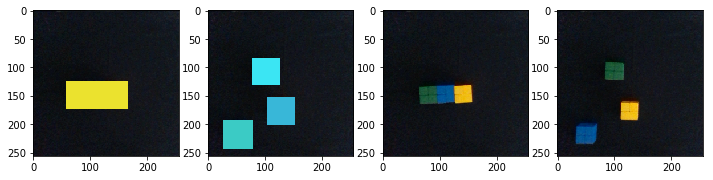

--------------------------------------------------
end





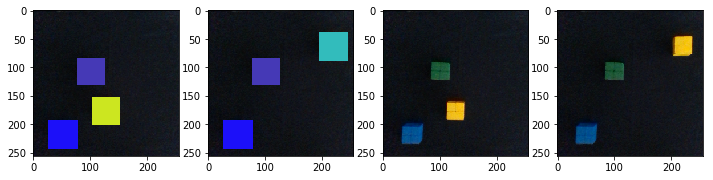

/home/obin/t2b_dataset/rgbd/sampled/0035.dat.gz


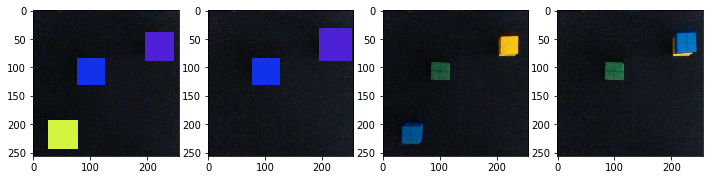

/home/obin/t2b_dataset/rgbd/sampled/0036.dat.gz


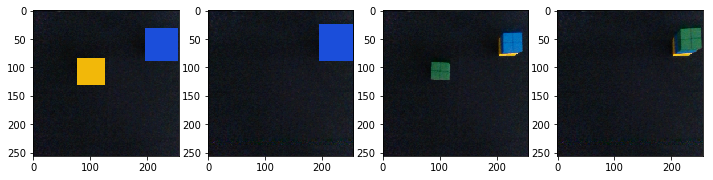

/home/obin/t2b_dataset/rgbd/sampled/0037.dat.gz


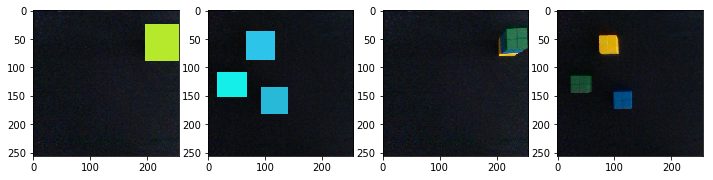

--------------------------------------------------
end





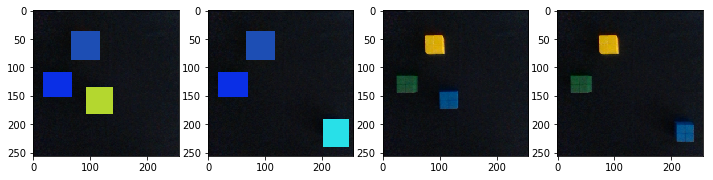

/home/obin/t2b_dataset/rgbd/sampled/0039.dat.gz


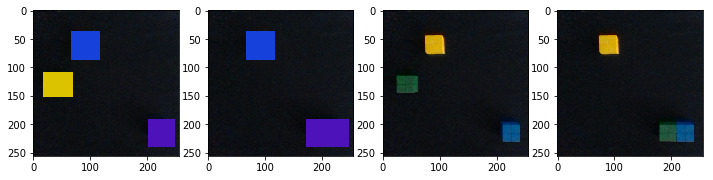

/home/obin/t2b_dataset/rgbd/sampled/0040.dat.gz


In [46]:
orig_imgs = []
end_scenario = []
resume = 0
white_image = np.zeros((30,300))
message = ''
for i in range(resume, num_data-1):

    s_img = cv2.imread(data_list[i])
    e_img = cv2.imread(data_list[i+1])

    s_hulls = extract_hulls(s_img)
    e_hulls = extract_hulls(e_img)

    s_objs = extract_objects(s_img,s_hulls,safe_distance=safe_distance)
    e_objs = extract_objects(e_img,e_hulls,safe_distance=safe_distance)

    
    fig = plt.figure(figsize=(12,12))
    s_ax = fig.add_subplot(141)
    s_img = cv2.cvtColor(s_img,cv2.COLOR_BGR2RGB)
    s_ax.imshow(s_img)
    e_ax = fig.add_subplot(142)
    e_img = cv2.cvtColor(e_img,cv2.COLOR_BGR2RGB)
    e_ax.imshow(e_img)    
    s_ax2 = fig.add_subplot(143)
    s_ax2.imshow(s_img)
    e_ax2 = fig.add_subplot(144)
    e_ax2.imshow(e_img)
    
    #plt.show()

    data_dict = dict()
    pair_idx = []
    no_care_idx = []
    
    paired_e_idx = []
    for s_idx, s_ob in enumerate(s_objs) :
        s_counter = [np.mean(s_ob[0:2]),np.mean(s_ob[2:4])]
        e_idx = where_is(s_counter,e_objs)

        if e_idx != -1 :
            e_ob = e_objs[e_idx]
            pair_idx.append([s_idx,e_idx])

            randcolor = (np.random.randint(0,70,size=3) + np.array([10,10,180]))/255.0
            rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                     linewidth=3,edgecolor=randcolor,facecolor=randcolor)
            s_ax.add_patch(rect)
            
            rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                                     linewidth=3,edgecolor=randcolor,facecolor=randcolor)
            e_ax.add_patch(rect)
            paired_e_idx.append(e_idx)
            
        else :
            randcolor = (np.random.randint(0,70,size=3) + np.array([180,180,0]))/255.0
            rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
                                     linewidth=3,edgecolor=randcolor,facecolor=randcolor)
            s_ax.add_patch(rect)
            no_care_idx.append([0,s_idx])
    
        for k in range(len(e_objs)):
            if k in paired_e_idx : continue
            else : 
                e_ob = e_objs[k]
                randcolor = (np.random.randint(0,70,size=3) + np.array([0,180,180]))/255.0
                rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
                         linewidth=3,edgecolor=randcolor,facecolor=randcolor)
                e_ax.add_patch(rect)
                no_care_idx.append([1,e_idx])
    
    plt.show()
    if len(pair_idx) == 0 :
        print('-'*50)
        print('end')
        print('\n\n')
        continue
        
    else :
        data_dict['start_image'] = s_img
        data_dict['end_image'] = e_img
        data_dict['pair_idx'] = pair_idx
        data_dict['no_care_idx'] = no_care_idx
        data_dict['start_objects'] = s_objs
        data_dict['end_objects'] = e_objs
        data_dict['start_hulls'] = s_hulls
        data_dict['end_hulls'] = e_hulls

        data_name = os.path.join('/home/obin/t2b_dataset/rgbd/sampled', '%04d.dat.gz'%i)
        #joblib.dump(data_dict,data_name)
        print(data_name)

            

            
    

In [41]:
a = []
if len(a) == 0 : print('empty')

empty


In [16]:
np.random.randint(50,200,size=3)

array([117,  77,  50])

In [17]:
data_path = '/home/obin/t2b_dataset/rgbd/sampled'
spd_list = np.sort([data_path+'/'+x for x in os.listdir(os.path.join(data_path,''))])
num_data = len(spd_list)

-------------scene 0-------------


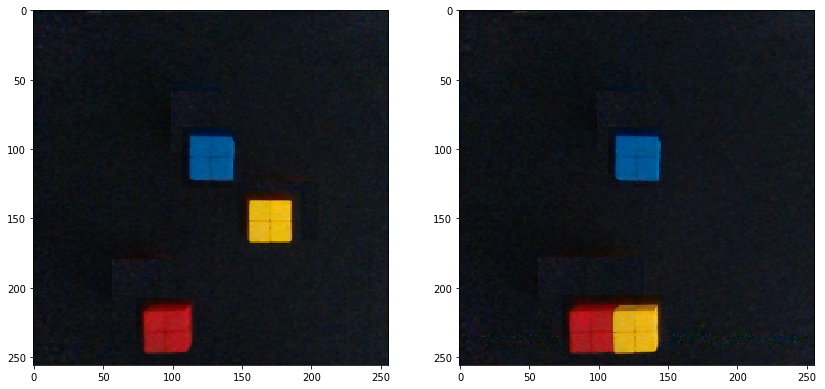

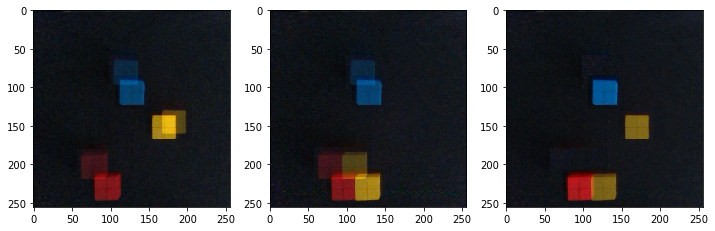

--------------------------------------------------




-------------scene 1-------------


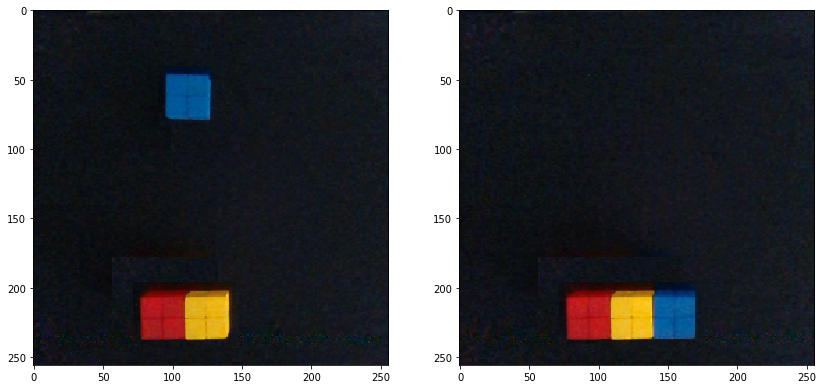

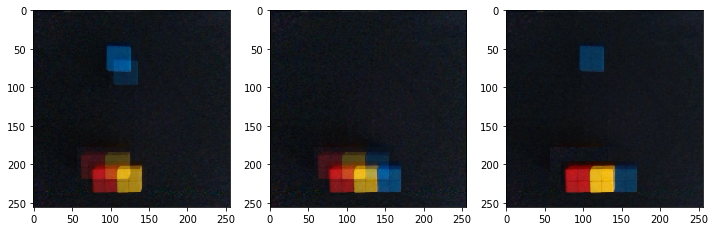

--------------------------------------------------




-------------scene 2-------------


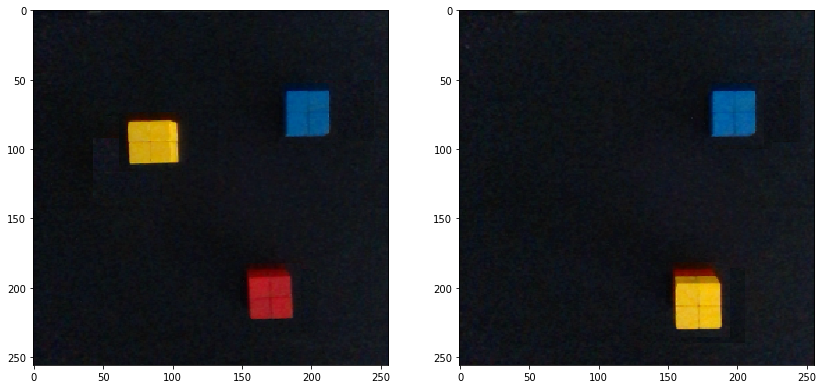

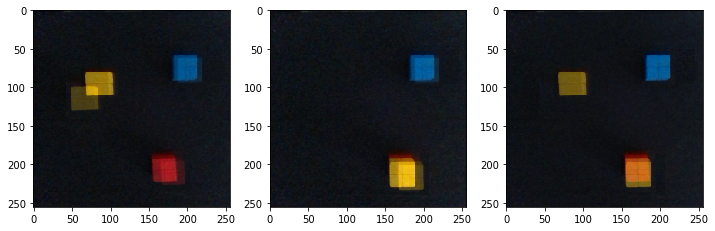

--------------------------------------------------




-------------scene 3-------------


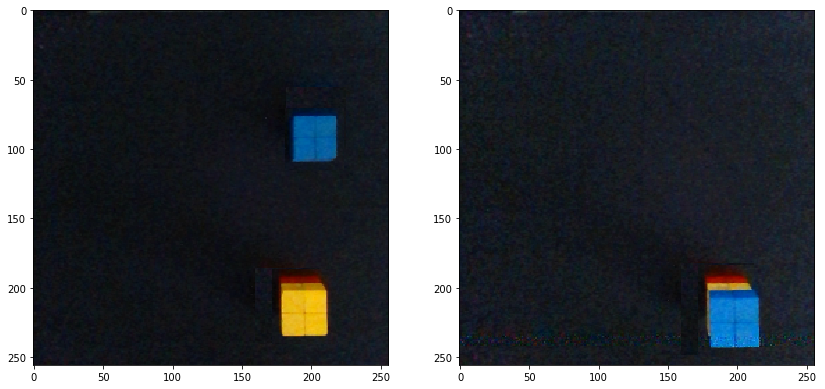

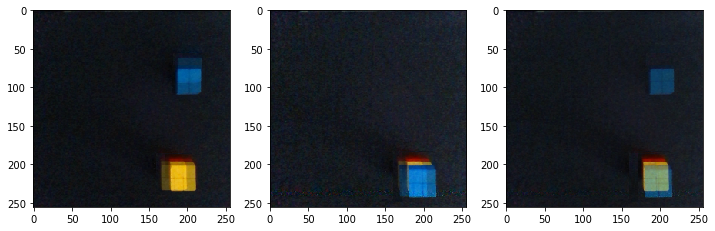

--------------------------------------------------




-------------scene 4-------------


KeyboardInterrupt: 

In [18]:
resume = 0
for i in range(resume, num_data):
    curr_data = joblib.load(spd_list[i])
    print('-------------scene {0}-------------'.format(i))
    s_img = copy.deepcopy(curr_data['start_image'])
    e_img = copy.deepcopy(curr_data['end_image'])
    pair_idx = curr_data['pair_idx']
    no_care_idx = curr_data['no_care_idx']
    s_objs = curr_data['start_objects']
    e_objs = curr_data['end_objects']
    s_hulls = curr_data['start_hulls']
    e_hulls = curr_data['end_hulls']

    
    for pair in pair_idx :
        for tr in range(6):
            move = np.ones(4)
            move[0:2] *= np.random.randint(-max_move1,max_move1+1)
            move[2:4] *= np.random.randint(-max_move1,max_move1+1)
            s, s_moved_img, s_moved_objs = move_object(pair[0],move,s_objs,s_img,black_patch)
            e, e_moved_img, e_moved_objs = move_object(pair[1],move,e_objs,e_img,black_patch)
            if s and e : 
                s_img = s_moved_img
                e_img = e_moved_img
                s_objs = s_moved_objs
                e_objs = e_moved_objs
                break

    for idx in no_care_idx :
        for tr in range(6):
            move = np.ones(4)
            move[0:2] *= np.random.randint(-max_move2,max_move2+1)
            move[2:4] *= np.random.randint(-max_move2,max_move2+1)
            
            if idx[0] == 0 : 
                result, moved_img, s_moved_objs = move_object(idx[1],move,s_objs,s_img,black_patch)
            elif idx[0] == 1:
                result, moved_img, e_moved_objs = move_object(idx[1],move,e_objs,e_img,black_patch)
            
            if result and idx[0] == 0 :
                s_img = moved_img
                s_objs = s_moved_objs
                break
            elif result and idx[0] == 1 :
                e_img = moved_img
                e_objs = e_moved_objs
                break
                
    plt.figure(figsize=(14,14))
    plt.subplot(121)
    plt.imshow(s_img)
    plt.subplot(122)
    
    plt.imshow(e_img)
    plt.show()
    
    plt.figure(figsize=(12,12))
    plt.subplot(131)
    plt.imshow(cv2.addWeighted(curr_data['start_image'],0.3,s_img,0.7,0))
    plt.subplot(132)
    plt.imshow(cv2.addWeighted(curr_data['end_image'],0.3,e_img,0.7,0))
    plt.subplot(133)
    plt.imshow(cv2.addWeighted(s_img,0.5,e_img,0.5,0))
    plt.show()
    print('-'*50)
    print('\n\n\n')

        
    

In [ ]:
s_objs[pair[0]][1]

In [ ]:
plt.imshow(cv2.cvtColor(s_img,cv2.COLOR_BGR2RGB))


In [ ]:
spd_list

In [32]:
## x_array = []
orig_imgs = []
resume = 69
for i in range(resume, num_data):
    img = cv2.imread(data_list[i])
    orig_img = copy.deepcopy(img)
    kernel = np.ones((3,3),np.float32)/(3*2)
    img = cv2.filter2D(img,-1,kernel)
    for tx in range(256):
        for ty in range(256):
            color = np.array(img[tx,ty,:],dtype=np.int64)
            if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
                img[tx,ty,:] = [30,30,30]

    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray,50,255,0)
    image, contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    hulls = []
    for c in contours :
        if np.array(c).shape[0] <= 1 : continue
        hulls.append(cv2.convexHull(c))
    print(len(hulls))
    image = cv2.drawContours(img, hulls, -1, (0,255,0), 3)
    cv2.imshow('contoured_image',image)
    key = cv2.waitKey()
    print('picture {0}'.format(i))
    
    
    object_list = []
    for h in hulls :
        x = np.array(h).squeeze()[:,0]
        y = np.array(h).squeeze()[:,1]
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        #out = np.zeros_like(img)
        dx = bottomx - topx
        dy = bottomy - topy


        out = img[topy:bottomy+1,topx:bottomx+1:]
        mean = np.mean(out, axis=(0,1))

        if dx*dy <= 800 : continue
        if (abs(mean[0] - mean[1]) < 20)and(abs(mean[1] - mean[2]) < 20) : continue
            
        obj = [topx-safe_distance,bottomx+safe_distance,
               topy-safe_distance,bottomy+safe_distance]
    
        object_list.append(np.clip(obj,0,255))

    
    for idx in range(len(object_list)) :
        ob = object_list[idx]
        for tr in range(6):
            move = np.ones(4)
            move[0:2] *= np.random.randint(-max_move1,max_move1+1)
            move[2:4] *= np.random.randint(-max_move1,max_move1+1)
            print('move ', move)
            moved_ob = np.array(ob-move,dtype=np.int64)
            if not(all(moved_ob<255) and all(moved_ob>0)) : continue
            print('moved', moved_ob)
            safe_flag = False
            for other_ob in object_list :
                if overlap(moved_ob,other_ob) and any(other_ob != ob) :
                    print('otverlap')
                    safe_flag=False
                    break
                safe_flag = True
            print(safe_flag)
            object_img = copy.deepcopy(orig_img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:])
            cv2.imshow('object',object_img)
            key = cv2.waitKey()
            if safe_flag : 
                dy = ob[3] - ob[2] + 1
                dx = ob[1] - ob[0] + 1
                orig_img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:] = black_patch[0:dy,0:dx,:]
                orig_img[moved_ob[2]:moved_ob[3]+1, moved_ob[0]:moved_ob[1]+1, :] = object_img
                object_list[idx] = moved_ob
            break
    
    #overlayed_image = cv2.addWeighted(img,0.2,orig_img,0.7,0)
    overlayed_image = orig_img
    orig_imgs.append(overlayed_image)
    if len(orig_imgs) > 2 :
        images = np.hstack((orig_imgs[len(orig_imgs)-2],orig_imgs[len(orig_imgs)-1]))
    else : 
        images = np.hstack((overlayed_image, orig_img))
    #cv2.imshow('images',images)
    #key = cv2.waitKey() 
    
    #cv2.destroyAllWindows()
        
        




    if key & 0xFF == ord('q') or key == 27:
        cv2.destroyAllWindows()
        break


    # Show the output image
#     cv2.imshow('Output', out)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    


picture 69
('move ', array([-16., -16.,   1.,   1.]))
('moved', array([151, 252, 186, 232]))
True
('move ', array([-7., -7., 15., 15.]))
('moved', array([ 33,  80,  63, 104]))
True
('move ', array([-16., -16., -10., -10.]))
('moved', array([206, 249,  85, 127]))
True
picture 70
('move ', array([-28., -28.,  26.,  26.]))
('moved', array([132, 171, 164, 205]))
otverlap
False
('move ', array([-24., -24.,   0.,   0.]))
('move ', array([ 3.,  3., 28., 28.]))
('moved', array([132, 233, 159, 205]))
otverlap
False
('move ', array([-7., -7., 17., 17.]))
('moved', array([197, 240,  58, 100]))
True


In [ ]:
object_list

In [ ]:
other_ob = [182, 240,  11,  72]

In [ ]:
all(moved_ob<255)

In [ ]:
object_img.shape

In [ ]:
np.array(ob).any() > 255